# Playlist Generation

### Goal: 

- Step 1: Top tracks: From a seed song find all top tracks from all related artists
- Step 2: Similar songs: From a seed song find all songs from related artists, and filter by similar songs based on Spotify API audio features 
- Step 3: Simple sampling to find the best playlist
- Step 4: Simulated Annealing to find the best playlist
- Step 5: Comparison and validation of methods

# Generate lists of candidate songs that fit into four buckets

**4 buckets of songs**

1. Top tracks from related artists
2. Tracks from related artists
3. Tracks from related artists identified as similar songs (using manhattan distance + Spotify API features)
3. Tracks from our database identified as similar (using raw audio  + vantage point method)

### Import Libraries and create spotify credentials manager

In [416]:
#!pip install pyemd

In [417]:
%matplotlib inline
import matplotlib.pyplot as plt
#importing module spotipy to make api calls to spotify
import spotipy
# module to extract song from url
import urllib
# OAuth Credenials
from spotipy.oauth2 import SpotifyClientCredentials
from multiprocessing import Process, Queue
import pandas as pd 
import numpy as np
from sklearn import datasets, linear_model
#from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
client_credentials_manager = SpotifyClientCredentials(client_id='4a1a457d14c0445a96e7021a5523905b', client_secret='45b186d601544fdcbb4fe07c7b23cce5')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
#importing module spotipy to make api calls to spotify
# module to extract song from url

# OAuth Credenials

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from scipy.optimize import linprog
from pyemd import emd


In [418]:
mean_features_data = pd.read_csv('mean_features_data_with_id.csv').drop('Unnamed: 0', axis = 1)
mean_features_data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,id
0,0.034331,0.027217,3.032119,0.100629,0.144193,0.094455,0.001504,0.038918,-20.449001,2.142264,...,0.000543,0.000259,0.000311,0.000444,0.000484,0.000725,0.000527,0.000368,0.000397,5bF6crgJa5Q58IWgbdUbuO
1,0.080249,0.063066,3.154067,0.179655,0.186982,0.676640,0.000210,0.105036,-17.555998,0.956587,...,0.000924,0.001856,0.000515,0.001718,0.001182,0.001021,0.001049,0.001231,0.000844,5BFMUpscSbYVT2V9j5d275
2,0.055129,0.094738,3.248476,0.168248,0.191879,0.350973,0.000328,0.043137,-17.683683,2.139082,...,0.001474,0.000988,0.001536,0.002911,0.000818,0.001129,0.000644,0.001056,0.001052,5bFxSkRAr1kiESBIkArOiP
3,0.035782,0.026939,3.152187,0.107575,0.149364,0.172294,0.001276,0.039265,-20.296906,2.452144,...,0.001199,0.002105,0.000745,0.002304,0.003827,0.003836,0.004233,0.003712,0.003389,5bG5GUKVJztKR5nff1CwUp
4,0.057428,0.062834,3.061450,0.131380,0.152100,0.427569,0.000472,0.075542,-17.584650,1.820407,...,0.000912,0.001501,0.002080,0.001376,0.002700,0.004059,0.001817,0.001280,0.002206,5BgC5vVuhfWHHawbcXRr7h


In [419]:
from sklearn.cluster import KMeans
cols = np.array(range(0,34))
kmeans = KMeans(n_clusters=300, random_state=0).fit(mean_features_data[cols])

In [420]:
def distance_between_clusters(mu_1, sig_1, mu_2, sig_2):
    
    means_diff_1 = mu_1- mu_2
    means_diff_2 = mu_2- mu_1
    sig_1_inv = np.linalg.inv(sig_1)
    sig_2_inv = np.linalg.inv(sig_2)
    dist = np.trace(np.dot(np.linalg.inv(sig_1) , sig_2)) + np.trace(np.dot(np.linalg.inv(sig_2) , sig_1)) + np.dot(np.dot(means_diff_1.T,sig_1_inv),means_diff_1) +np.dot(np.dot(means_diff_2.T,sig_2_inv),means_diff_2) 
    return dist


In [421]:
# code to calculate emd between two songs
def calc_emd(signature_1, signature_2):
    p_list = []
    for i in signature_1['weights']:
        p_list.append(i)
    
    q_list = []
    for i in signature_2['weights']:
        q_list.append(i)
    
    clus_1 = signature_1['means'].shape[0]
    clus_2 = signature_2['means'].shape[0]
    dist = np.zeros((clus_1*clus_2))
    p_list = np.array(p_list)
    q_list = np.array(q_list)
    col = 0
    for i in range(0, clus_1):
        for j in range(0, clus_2):
            dist[col]=distance_between_clusters(signature_1['means'][i],signature_1['var'][i], signature_2['means'][j], signature_2['var'][j])
            col+=1
    #clus_1 = clus_2 = 4
    A_ub = np.zeros((clus_1+clus_2, clus_1*clus_2))
    j = 0
    for i in range(0, clus_1):
        A_ub[i][j:j+clus_2] = 1
        j+=clus_2

    #print(A_ub)
    k = 0
    for i in range(clus_1, clus_1+clus_2):
        
        for j in range(k, clus_1*clus_2, clus_2):
            
            A_ub[i][j] = 1
        k = k+1
    #print(A_ub)
    b_ub = np.zeros(clus_1 + clus_2)
    b_ub[0:clus_1] = p_list
    b_ub[clus_1:] = q_list
    A_eq = np.ones((1,clus_1*clus_2))
    b_eq = min(np.sum(p_list), np.sum(q_list))

    res = linprog(c = dist,A_ub = A_ub,b_ub= b_ub,A_eq = A_eq, b_eq = b_eq,options={"disp": True})
    
    f_star = np.array(res['x'])

    num = np.dot(f_star, dist)
    denom = np.sum(f_star)
    #print(f_star, num, denom)
    return(num/denom)


    
# example for two songs

# p_list = np.array([0.2, 0.8])
# q_list = np.array([0.8, 0.2])

# c = np.array([[0,1],[1,0]])
# c = np.transpose(np.ravel(c))
# print("c",c)
# A_ub  = np.array([[1,1,0,0], [0,0,1,1], [1,0,1,0], [0,1,0,1]])
# print("A_ub",A_ub)
# b_ub  =np.array([p_list[0], p_list[1], q_list[0], q_list[1]])
# b_ub = np.transpose(b_ub)
# print("b_ub ", b_ub)
# A_eq = np.array([[1,1,1,1]])
# b_eq = min(np.sum(p_list), np.sum(q_list))
# #print(A_eq, b_eq)
# res = linprog(c = c,A_ub = A_ub,b_ub= b_ub,A_eq = A_eq, b_eq = b_eq,options={"disp": True})
# f_star = np.array(res['x'])
# num = np.dot(f_star, c)
# denom = np.sum(f_star)
# print(num/denom)




In [422]:
track_id = pd.read_csv('track_id_new.csv')

### Read in csv that has the track ids from all Spotify playlists

In [423]:
track_info = pd.read_csv("kmeans_output.csv")
track_ids = list(track_info['id'])
print(len(track_ids), "example track ids", "\n")
print(track_ids[:15])
track_result = sp.tracks(["1tpShM80HMT9vKjRiA3EzW"])

14887 example track ids 

['1tPGSiwtvmMVAqmniJ7oHp', '1tpShM80HMT9vKjRiA3EzW', '1TPUbLdzpfgF7wrPEXIAAB', '1tQGRq2WOBXjL3JWdWMONg', '1TqmZVIyeD4aN4Wa0wbnfy', '1TquBahz02HCaxj8jy5tTo', '1Tr4K5MU5XYE44umXGDndd', '1tRlCCMVLSVQrrN9PPgtf0', '1TScJLsDWzDVBFpCU5vJDo', '1TSjS0q24cPW2S4pYj2wEK', '1Tt4sE4pXi57mTD1GCzsqm', '1TtdHZ4KvN56LCt9evBUaL', '1TTiZwoorWMR4KmaI0irjU', '1TtJJ7YP6JCQ3aH8PQpreD', '1TTOAw90zzNWKnUgzzcvZW']


---------

### Input a seed track

In [424]:
seed_id = '7k2lqQ4Vt9435X24qUISki'# "7qiZfU4dY1lWllzX7mPBI3" #'6txo4X8yd8FekwFFtI82Ea' #
track_info = sp.tracks([seed_id])
name = track_info['tracks'][0]['name']
seed_preview_url = track_info['tracks'][0]['preview_url']
print("ID: ", seed_id, "\n \n Artist name: ",track_info['tracks'][0]['artists'][0]['name'], "\n Track name: ",name)

ID:  7k2lqQ4Vt9435X24qUISki 
 
 Artist name:  Ciele 
 Track name:  Daydream


### Get the track's artists

In [425]:
artist_names = []
artist_ids = []
for each in track_info['tracks'][0]['artists']:
    artist_names.append(each['name'])
    artist_ids.append(each['id'])
print(artist_names)
print(artist_ids,"\n")
print(len(artist_names), "artist(s)")

[u'Ciele', u'Chris Ho']
[u'1ox8Ch0uaAeuJvVyKO8Okg', u'3RKOByto5bCzCDjK5ViM6w'] 

2 artist(s)


In [426]:
artist_ids

[u'1ox8Ch0uaAeuJvVyKO8Okg', u'3RKOByto5bCzCDjK5ViM6w']

### Get related artists

In [427]:
all_related_artists_names = []
all_related_artists_ids = []
all_related_artists_names.extend(artist_names)
all_related_artists_ids.extend(artist_ids)

for each in artist_ids:
    print(each)
    related = sp.artist_related_artists(each)
    for related_artist in related['artists']:
        all_related_artists_names.append(related_artist['name'])
        all_related_artists_ids.append(related_artist['id'])
all_related_artists_ids = np.array(all_related_artists_ids)
all_related_artists_ids_unique = np.unique(all_related_artists_ids)
print(len(all_related_artists_ids_unique), "related artists")

1ox8Ch0uaAeuJvVyKO8Okg
3RKOByto5bCzCDjK5ViM6w
42 related artists


### Bucket #1: Top tracks from the related artists

In [428]:
top_tracks_related_artists = []
for each in all_related_artists_ids_unique:    
    top_tracks_one_artist = sp.artist_top_tracks(each)

    for each in top_tracks_one_artist['tracks']:
        song = each['id']
        top_tracks_related_artists.append(song)
        
print(len(top_tracks_related_artists),"top tracks from related artists")

336 top tracks from related artists


### Bucket #2: Songs from related artists that are not in top tracks but are similar

In [429]:
print("Finding albums from related artists...")
all_related_albums = []
for each in all_related_artists_ids_unique:    
    albums = sp.artist_albums(each, album_type=None, country=None, limit=50, offset=0)
    for each in albums['items']:
        album_id = each['id']
        all_related_albums.append(album_id)
sp.album_tracks(all_related_albums[1], limit=50, offset=0)
print("Finding songs from those albums...")

all_related_songs = []
all_related_preview_urls = []
for index, each_album in enumerate(all_related_albums):
    album_tracks = sp.album_tracks(each_album, limit=50, offset=0)
    if index%50==0: print(index)
    for each in album_tracks['items']:
        all_related_songs.append(each['id'])
        all_related_preview_urls.append(each['preview_url'])
all_related_songs = np.array(all_related_songs)
all_related_songs = list(np.unique(all_related_songs))
combined = [seed_id]
combined.extend(all_related_songs)
all_related_songs = combined
print(len(all_related_songs), " songs from related artists")

Finding albums from related artists...
Finding songs from those albums...
0
50
100
150
200
250
300
350
2729  songs from related artists


### Test to make sure the songs sound like they're from related artists

In [430]:
from IPython.core.display import HTML

In [431]:
link = '<a href=' + str(seed_preview_url) + '>preview input song</a>'
#display(HTML(link))
HTML(link)


In [432]:
link = '<a href=' + str(all_related_preview_urls[10]) + '>preview related song</a>'
HTML(link)


### Bucket 4

In [433]:
def return_candidate_songs(seed_song): # seed_song is the track_id
    
    # extract raw audio #
    track_spotify = sp.tracks([seed_song])['tracks'][0]
        
    
    #print(track_spotify['preview_url'])  
    urllib.urlretrieve(track_spotify['preview_url'], "track"+track_spotify['id']+".wav")
                    
    # extract acoustic features
    
#     [Fs, x] = audioBasicIO.readAudioFile("track"+track_spotify['id']+".wav");
#     F = audioFeatureExtraction.stFeatureExtraction(x[:,1], Fs, 1* Fs, 1*Fs);
    F = pd.read_csv(seed_song + '.csv', header = None)
    print(F.shape)
#     # predict the nearest vantage point
    vp_nearest = kmeans.predict(np.mean(F, axis = 1).reshape(1,-1))
    print(vp_nearest)
    #All songs in that cluster
    nearest_song_index = np.where(kmeans.labels_ == vp_nearest)
    return(track_id.iloc[nearest_song_index]['trackid'].values)
bucket4_ids = return_candidate_songs('7qiZfU4dY1lWllzX7mPBI3')

(34, 30)
[294]


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


### Function to get Spotify API features given a list of track ids

In [434]:
def get_spotify_features(track_ids,numLoops=None):
    track_ids_all= []
    popularity = []
    preview_urls_all =[]
    artists_all = []
    names_all = []
    track_numbers_all = []
    num_markets = []
    
    # set parameters
    offset=0
    limit=50
    if numLoops==None: 
        numLoops=int(math.floor(len(track_ids)/50)+1)
    aud_features = np.empty((limit*numLoops, 13))
    for loopIndex in range(numLoops):
        start = offset + limit*loopIndex # start 
        tracks = track_ids[start:start+limit]
        try:
            tracks_list = sp.tracks(tracks)
            features = sp.audio_features(tracks=tracks)
        except:
            print("Couldn't get data", index)
            continue
        for index, track in enumerate(tracks_list['tracks']):
            
            try:
                if (start+index)%1000==0: 
                    print(index+1+start)
                preview_urls_all.append(track['preview_url'])
                track_ids_all.append(track['id'])
                popularity.append(track['popularity'])
                names_all.append(track['name'])
                artists_all.append(track['artists'][0]['name'])
                track_numbers_all.append(track['track_number'])
                num_markets.append(track['available_markets'])
                songData = features[index]
                aud_features[index+start][0] = songData['acousticness']
                aud_features[index+start][1] = songData['danceability']
                aud_features[index+start][2] = songData['energy']
                aud_features[index+start][3] = songData['instrumentalness']
                aud_features[index+start][4] = songData['key']
                aud_features[index+start][5] = songData['liveness']
                aud_features[index+start][6] = songData['loudness']
                aud_features[index+start][7] = songData['mode']
                aud_features[index+start][8] = songData['tempo']
                aud_features[index+start][9] = songData['time_signature']
                aud_features[index+start][10] = songData['valence']
                aud_features[index+start][11] = songData['duration_ms']
                aud_features[index+start][12] = songData['speechiness']
                 
            except:
                print("Some fields not available", index)

    aud_features = aud_features[:len(names_all),]
    track_data = pd.DataFrame({
    'preview_url': preview_urls_all,
    'id': track_ids_all,
    'popularity': popularity,
    'artists': artists_all,
    'names': names_all,
    'acousticness': aud_features[:,0],
    'danceability': aud_features[:,1],
    'energy': aud_features[:,2],
    'instrumentalness': aud_features[:,3],
    'key': aud_features[:,4],
    'liveness': aud_features[:,5],
    'loudness': aud_features[:,6],
    'mode': aud_features[:,7],
    'tempo': aud_features[:,8],
    'time_signature': aud_features[:,9],
    'valence': aud_features[:,10],
    'duration': aud_features[:,11],
    'speechiness': aud_features[:,12],
    'available_markets': num_markets
    
   
    })
    #q.put(track_data)
    print(len(num_markets), len(popularity), aud_features.shape)
    #name = multiprocessing.current_process().name
    print('Exiting')
    return track_data


### Get all Spotify features for Bucket 1

In [435]:
print(len(top_tracks_related_artists))
top_tracks_df = get_spotify_features(track_ids=top_tracks_related_artists) 

336
1
336 336 (336, 13)
Exiting


In [436]:
top_tracks_df.head()

,acousticness,artists,available_markets,danceability,duration,energy,id,instrumentalness,key,liveness,loudness,mode,names,popularity,preview_url,speechiness,tempo,time_signature,valence
0,0.04640,Humpback Oak,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.465,218333.0,0.755,5UMrTvoee2LLiwXlq2Kisa,0.006060,5.0,0.0999,-11.004,0.0,Lower Girl,1,https://p.scdn.co/mp3-preview/1f484f32e8added8...,0.0276,143.879,4.0,0.861
1,0.04940,The Nonames,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.501,223244.0,0.685,00PeEIoBs1WTVrW8AVBc4w,0.000000,1.0,0.1800,-8.973,1.0,Resurrection Kid,2,https://p.scdn.co/mp3-preview/157f0d32a685ef34...,0.3690,85.494,5.0,0.425
2,0.08230,The Nonames,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.482,227199.0,0.761,79PzUCoYq6Co89mxICQOH8,0.000033,8.0,0.1840,-10.955,1.0,Shallow,0,https://p.scdn.co/mp3-preview/ea42572a49b46a7e...,0.4110,79.131,4.0,0.471
3,0.00651,The Nonames,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.558,256351.0,0.955,0RAsLh8vE0jyEWiwEHET6L,0.918000,9.0,0.3170,-6.272,1.0,Come On Shoot A Goal - England Anthem,0,https://p.scdn.co/mp3-preview/72292364ad15f325...,0.0423,130.010,4.0,0.710
4,0.04120,The Nonames,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.407,202857.0,0.847,4ogWT57PF2GiA0JK2SoInN,0.886000,0.0,0.2590,-11.896,1.0,Pepinako,0,https://p.scdn.co/mp3-preview/c942da15728064ef...,0.1290,82.480,4.0,0.223


In [437]:
top_tracks_df = top_tracks_df.dropna()
top_tracks_df = top_tracks_df.reset_index(drop=True)

### Get Spotify API Features for Bucket 2

In [438]:
features_df = get_spotify_features(track_ids=all_related_songs)

1
1001
2001
2729 2729 (2729, 13)
Exiting


In [439]:
features_df.head()

,acousticness,artists,available_markets,danceability,duration,energy,id,instrumentalness,key,liveness,loudness,mode,names,popularity,preview_url,speechiness,tempo,time_signature,valence
0,0.69800,Ciele,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.685,218404.0,0.2120,7k2lqQ4Vt9435X24qUISki,0.000045,4.0,0.1660,-11.233,1.0,Daydream,54,https://p.scdn.co/mp3-preview/db320fd9db78da2f...,0.0354,139.955,3.0,0.299
1,0.00255,The Great Spy Experiment,"[AR, AT, AU, BE, BO, BR, CH, CL, CO, CR, CY, C...",0.428,329627.0,0.8180,006J0U8vgXGcXvyAX1dIVQ,0.427000,0.0,0.0817,-5.713,1.0,In The Sun,10,None,0.0461,128.026,4.0,0.119
2,0.09060,Leigh Nash,"[AT, CH, DE, LI]",0.175,300800.0,0.5650,00INNo7RXNNClwc22p1nNM,0.000003,1.0,0.1570,-6.315,0.0,With Every Breath,0,https://p.scdn.co/mp3-preview/5ff7eaa7f6f5e714...,0.0336,82.964,4.0,0.182
3,0.27000,Imaginary Future,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.675,214367.0,0.6040,00Jn6weiHJPHb4B0ZAHmrG,0.000000,8.0,0.1380,-6.567,1.0,Sunlight,27,None,0.0244,146.005,4.0,0.613
4,0.90300,Imaginary Future,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.673,208407.0,0.0966,00NVEk72v1fLLZL36jKqhT,0.005110,6.0,0.1120,-19.641,1.0,Wherever You Go,20,https://p.scdn.co/mp3-preview/673ceb45cbeff158...,0.0317,104.950,4.0,0.197


In [440]:
features_df = features_df.dropna()
features_df = features_df.reset_index(drop=True)

## Find most similar songs acoustically

### Calculate the distance between the input song and related songs

In [441]:
from scipy.spatial.distance import cityblock
distance_features = features_df[['acousticness', 'danceability', 
                                 'duration', 'energy', 'instrumentalness', 'liveness', 
                                 'loudness', 'speechiness', 'tempo', 'valence']]
distance_features.head()

,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.6980,0.685,218404.0,0.2120,0.000045,0.1660,-11.233,0.0354,139.955,0.299
1,0.0906,0.175,300800.0,0.5650,0.000003,0.1570,-6.315,0.0336,82.964,0.182
2,0.9030,0.673,208407.0,0.0966,0.005110,0.1120,-19.641,0.0317,104.950,0.197
3,0.0494,0.501,223244.0,0.6850,0.000000,0.1800,-8.973,0.3690,85.494,0.425
4,0.3380,0.545,196547.0,0.5840,0.000001,0.0931,-7.174,0.0297,132.261,0.604


In [442]:
seed_features = distance_features.ix[0,]
related_features = distance_features.ix[1:,]
print(len(related_features))
sample_size = len(related_features)
distance_vector = np.empty((sample_size))
for index,row in related_features.iterrows():
    if index>sample_size-1: break
    #print(row)
    distance_vector[index]=cityblock(seed_features, row)
print(distance_vector.shape)
#distance_vector[10015]

2640
(2640,)


### Sort the distance output and find the 500 most acoustically similar songs

In [443]:
from IPython.display import HTML, display
min_indices = distance_vector.argsort()[0:500:]
top_similarity_index = min_indices[2]
top_similarity_index
related_all_features_with_seed = features_df.ix[:]
seed_all_features = features_df.ix[0,]
link = '<a href=' + str(seed_all_features['preview_url']) + '>preview seed song</a>'
display(HTML(link))
for each in range(10):
    print(related_all_features_with_seed['artists'][min_indices[each]])
    print(related_all_features_with_seed['artists'][min_indices[each]], related_all_features_with_seed['id'][min_indices[each]])
    link = '<a href=' + str(related_all_features_with_seed['preview_url'][min_indices[each]]) + '>preview related song #'+str(each)+ '</a>'
    display(HTML(link))

Ciele
Ciele 7k2lqQ4Vt9435X24qUISki


Ciele
Ciele 7k2lqQ4Vt9435X24qUISki


Craig Cardiff
Craig Cardiff 7q7giLDRB8BdE2omYzv7EV


Humpback Oak
Humpback Oak 5UMrTvoee2LLiwXlq2Kisa


Craig Cardiff
Craig Cardiff 2sG3a7VLWgifQJ9NHYIOVz


Lori Lieberman
Lori Lieberman 1f4W78UL8izjwSGhQa9dXd


Leonard T
Leonard T 7cinlbzzEWJtJjDkDmx5O4


Craig Cardiff
Craig Cardiff 4viyKGiVj92VvsQCDTXrFE


Tom Munch
Tom Munch 3xnNpmGE52bMOXKPIZnZsQ


Lori Lieberman
Lori Lieberman 1XOuBNYq60EyaEmJ15MxaW


In [444]:
#features_df.to_csv('related_songs.csv', encoding='utf-8')

### Bucket 1: Top tracks from related artists

In [445]:
print(top_tracks_df.shape)
nona = top_tracks_df.drop_duplicates(subset='id', keep='first', inplace=False)
print(nona.shape)
bucket1 = nona['id'].values
bucket1[:5]

(334, 19)
(332, 19)


array([u'5UMrTvoee2LLiwXlq2Kisa', u'00PeEIoBs1WTVrW8AVBc4w',
       u'79PzUCoYq6Co89mxICQOH8', u'0RAsLh8vE0jyEWiwEHET6L',
       u'4ogWT57PF2GiA0JK2SoInN'], dtype=object)

### Bucket 2: Any tracks from related artists

In [446]:
nona = features_df.drop_duplicates(subset='id', keep='first', inplace=False)
print(nona.shape)
all_related_songs = nona['id'].values
print(all_related_songs.shape)
bucket2 = all_related_songs
bucket2[:5]

(2640, 19)
(2640,)


array([u'7k2lqQ4Vt9435X24qUISki', u'00INNo7RXNNClwc22p1nNM',
       u'00NVEk72v1fLLZL36jKqhT', u'00PeEIoBs1WTVrW8AVBc4w',
       u'00Y1JrxdwDRLl6BUlXjpKZ'], dtype=object)

### Bucket 3: Tracks from related artists identified as similar songs (using manhattan distance + Spotify API features)

In [447]:
bucket3 = related_all_features_with_seed['id'][min_indices].values
bucket3[:5]

array([u'7k2lqQ4Vt9435X24qUISki', u'7k2lqQ4Vt9435X24qUISki',
       u'7q7giLDRB8BdE2omYzv7EV', u'5UMrTvoee2LLiwXlq2Kisa',
       u'2sG3a7VLWgifQJ9NHYIOVz'], dtype=object)

### Bucket 4: Tracks from our database identified as similar (using raw audio  + vantage point method)

In [448]:
bucket4_df = get_spotify_features(track_ids=bucket4_ids)

1
97 97 (97, 13)
Exiting


In [449]:
bucket4_df = bucket4_df.dropna()
bucket4_df = bucket4_df.reset_index(drop=True)
bucket4 = bucket4_df['id'].values

# Optimization

### Train Random Forest Model

In [450]:
## Popularity Prediction for New Playlist

#libraries

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import train_test_split
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys
from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1 - train the random forest

api_data = pd.read_csv('playlist_data_with_sequencing_4.8.17.csv')
api_data = api_data.dropna()
del api_data['Unnamed: 0']
del api_data['names']
del api_data['playlist_id']
api_data.head()

a = pd.qcut(api_data["followers"], 5,labels=range(1,6))
api_data['followers'] = np.array(a)

y = api_data['followers']
X = api_data.drop(['followers'],axis=1)
X = X.drop(['featured'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


rfc = RFC(n_estimators = 100, max_depth = 29)
rfc.fit(X_train, y_train)

client_credentials_manager = SpotifyClientCredentials(client_id='df846cfd28e745178054587b3484f91c',client_secret='e3d39fc92a954e028ff1490288f3fe5c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


### Function to generate predicted class probabilities for playlist popularity from a list of input track ids

In [451]:
def getTrack(track_id):
    #print(track_id)
    try:
        listing = features_df[features_df['id']==track_id]
        popularity = listing['popularity'].values[0]
    except IndexError:
        try:
            listing = top_tracks_df[top_tracks_df['id']==track_id]
            popularity = listing['popularity'].values[0]
        except IndexError:
            listing = bucket4_df[bucket4_df['id']==track_id]      
            popularity = listing['popularity'].values[0]
    num_markets = listing['available_markets'].values[0]
    return {"popularity": popularity,
           'available_markets': num_markets}

def getAudioFeatures(list_of_ids):
    try:
        listing = features_df[features_df['id'].isin(list_of_ids)]
        acousticness = listing['acousticness'].values[0]
    except:
        listing = top_tracks_df[top_tracks_df['id'].isin(list_of_ids)]
        if listing.shape[0]==0:
            listing = bucket4_df[bucket4_df['id'].isin(list_of_ids)]
    return listing[['acousticness', 'danceability', 'energy', 'instrumentalness', 'key','liveness', 'loudness', 'mode','tempo','time_signature','valence','duration']].values
def chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
        
    return out

def gen_row(list_of_tracks):
            
    parts = chunks(list_of_tracks,4)
                    
    p1 = parts[0]
    p2 = parts[1]
    p3 = parts[2]
    p4 = parts[3]
    
    t_popularities = []
    t_num_markets = []
                
    for track in list_of_tracks:
        listing = getTrack(track)
        t_popularities.append(listing['popularity'])
        t_num_markets.append(len(listing['available_markets']))
                                        
    t_pop = np.mean(t_popularities)
    t_av_num_markets = np.mean(t_num_markets)

    #t_features = sp.audio_features(tracks = list_of_tracks)
    feat_len = len(list_of_tracks)
    #t_feature_matrix = np.empty((feat_len,12))
    t_feature_matrix = getAudioFeatures(list_of_tracks)
#     for ix, song in enumerate(t_features):
  
#         t_feature_matrix[ix][0] = song['acousticness']
#         t_feature_matrix[ix][1] = song['danceability']
#         t_feature_matrix[ix][2] = song['energy']
#         t_feature_matrix[ix][3] = song['instrumentalness']
#         t_feature_matrix[ix][4] = song['key']
#         t_feature_matrix[ix][5] = song['liveness']
#         t_feature_matrix[ix][6] = song['loudness']
#         t_feature_matrix[ix][7] = song['mode']
#         t_feature_matrix[ix][8] = song['tempo']
#         t_feature_matrix[ix][9] = song['time_signature']
#         t_feature_matrix[ix][10] = song['valence']
#         t_feature_matrix[ix][11] = song['duration_ms']
                            
    t_feature_median = np.percentile(t_feature_matrix,50,axis=0)
                    # Part 1
                    
    p1_popularities = []
    p1_num_markets = []
                    
    for track in p1:
        listing = getTrack(track)
        p1_popularities.append(listing['popularity'])
        p1_num_markets.append(len(listing['available_markets']))
    
    p1_pop = np.mean(p1_popularities)
    p1_av_num_markets = np.mean(p1_num_markets)
    
    #p1_features = sp.audio_features(tracks = p1)
    p1_len = len(p1)
    #p1_feature_matrix = np.empty((p1_len,12))
    p1_feature_matrix = getAudioFeatures(p1)
                    
#     for ix, song in enumerate(p1_features):
#         p1_feature_matrix[ix][0] = song['acousticness']
#         p1_feature_matrix[ix][1] = song['danceability']
#         p1_feature_matrix[ix][2] = song['energy']
#         p1_feature_matrix[ix][3] = song['instrumentalness']
#         p1_feature_matrix[ix][4] = song['key']
#         p1_feature_matrix[ix][5] = song['liveness']
#         p1_feature_matrix[ix][6] = song['loudness']
#         p1_feature_matrix[ix][7] = song['mode']
#         p1_feature_matrix[ix][8] = song['tempo']
#         p1_feature_matrix[ix][9] = song['time_signature']
#         p1_feature_matrix[ix][10] = song['valence']
#         p1_feature_matrix[ix][11] = song['duration_ms']
    p1_feature_median = np.percentile(p1_feature_matrix,50,axis=0)
    
                    # Part 2
                    
    p2_popularities = []
    p2_num_markets = []
                    
    for track in p2:
        listing = getTrack(track)
        p2_popularities.append(listing['popularity'])
        p2_num_markets.append(len(listing['available_markets']))
    
    p2_pop = np.mean(p2_popularities)
    p2_av_num_markets = np.mean(p2_num_markets)
    
    #p2_features = sp.audio_features(tracks = p2)

    p2_len = len(p2)
    #p2_feature_matrix = np.empty((p2_len,12))
    p2_feature_matrix = getAudioFeatures(p2)
                 
#     for ix, song in enumerate(p2_features):
#         p2_feature_matrix[ix][0] = song['acousticness']
#         p2_feature_matrix[ix][1] = song['danceability']
#         p2_feature_matrix[ix][2] = song['energy']
#         p2_feature_matrix[ix][3] = song['instrumentalness']
#         p2_feature_matrix[ix][4] = song['key']
#         p2_feature_matrix[ix][5] = song['liveness']
#         p2_feature_matrix[ix][6] = song['loudness']
#         p2_feature_matrix[ix][7] = song['mode']
#         p2_feature_matrix[ix][8] = song['tempo']
#         p2_feature_matrix[ix][9] = song['time_signature']
#         p2_feature_matrix[ix][10] = song['valence']
#         p2_feature_matrix[ix][11] = song['duration_ms']
                        
    p2_feature_median = np.percentile(p2_feature_matrix,50,axis=0)
    
                        # Part 3
                    
    p3_popularities = []
    p3_num_markets = []
                  
    for track in p3:
        listing = getTrack(track)
        p3_popularities.append(listing['popularity'])
        p3_num_markets.append(len(listing['available_markets']))
    
    p3_pop = np.mean(p3_popularities)
    p3_av_num_markets = np.mean(p3_num_markets)
    
    #p3_features = sp.audio_features(tracks = p3)
    p3_len = len(p3)
    #p3_feature_matrix = np.empty((p3_len,12))
    p3_feature_matrix = getAudioFeatures(p3)
                
#     for ix, song in enumerate(p3_features):
#         p3_feature_matrix[ix][0] = song['acousticness']
#         p3_feature_matrix[ix][1] = song['danceability']
#         p3_feature_matrix[ix][2] = song['energy']
#         p3_feature_matrix[ix][3] = song['instrumentalness']
#         p3_feature_matrix[ix][4] = song['key']
#         p3_feature_matrix[ix][5] = song['liveness']
#         p3_feature_matrix[ix][6] = song['loudness']
#         p3_feature_matrix[ix][7] = song['mode']
#         p3_feature_matrix[ix][8] = song['tempo']
#         p3_feature_matrix[ix][9] = song['time_signature']
#         p3_feature_matrix[ix][10] = song['valence']
#         p3_feature_matrix[ix][11] = song['duration_ms']
                        
    p3_feature_median = np.percentile(p3_feature_matrix,50,axis=0)
    
                        # Part 4
                    
    p4_popularities = []
    p4_num_markets = []
                    
    for track in p4:
        listing = getTrack(track)
        p4_popularities.append(listing['popularity'])
        p4_num_markets.append(len(listing['available_markets']))
    
    p4_pop = np.mean(p4_popularities)
    p4_av_num_markets = np.mean(p4_num_markets)
    
    #p4_features = sp.audio_features(tracks = p4)
    p4_len = len(p4)
    #p4_feature_matrix = np.empty((p4_len,12))
    p4_feature_matrix = getAudioFeatures(p4)
             
#     for ix, song in enumerate(p4_features):
#         p4_feature_matrix[ix][0] = song['acousticness']
#         p4_feature_matrix[ix][1] = song['danceability']
#         p4_feature_matrix[ix][2] = song['energy']
#         p4_feature_matrix[ix][3] = song['instrumentalness']
#         p4_feature_matrix[ix][4] = song['key']
#         p4_feature_matrix[ix][5] = song['liveness']
#         p4_feature_matrix[ix][6] = song['loudness']
#         p4_feature_matrix[ix][7] = song['mode']
#         p4_feature_matrix[ix][8] = song['tempo']
#         p4_feature_matrix[ix][9] = song['time_signature']
#         p4_feature_matrix[ix][10] = song['valence']
#         p4_feature_matrix[ix][11] = song['duration_ms']
                        
    p4_feature_median = np.percentile(p4_feature_matrix,50,axis=0)
           
    playlist_data = pd.Series({
                    #'followers': followers,
                    #'names' : names,
                    #'playlist_id' : playlist_ids,
                    'total_tracks' : len(list_of_tracks),
                    #'featured' : featured,
                    'acousticness': p1_feature_median[0],
                    'danceability': p1_feature_median[1],
                    'energy': p1_feature_median[2],
                    'instrumentalness': p1_feature_median[3],
                    'key': p1_feature_median[4],
                    'liveness': p1_feature_median[5],
                    'loudness': p1_feature_median[6],
                    'mode': p1_feature_median[7],
                    'tempo': p1_feature_median[8],
                    'time_signature': p1_feature_median[9],
                    'valence': p1_feature_median[10],
                    'duration': p1_feature_median[11],
                    'popularity':np.mean(t_pop),
                    'mean_num_markets': np.mean(t_av_num_markets),
                    #'avg_years' : t_release_date,

                    'p1_acousticness': p1_feature_median[0],
                    'p1_danceability': p1_feature_median[1],
                    'p1_energy': p1_feature_median[2],
                    'p1_instrumentalness': p1_feature_median[3],
                    'p1_key': p1_feature_median[4],
                    'p1_liveness': p1_feature_median[5],
                    'p1_loudness': p1_feature_median[6],
                    'p1_mode': p1_feature_median[7],
                    'p1_tempo': p1_feature_median[8],
                    'p1_time_signature': p1_feature_median[9],
                    'p1_valence': p1_feature_median[10],
                    'p1_duration': p1_feature_median[11],
                    'p1_popularity': p1_pop,
                    'p1_mean_num_markets': p1_av_num_markets,
                    #'p1_avg_years': p1_release_date,

                    'p2_acousticness': p2_feature_median[0],
                    'p2_danceability': p2_feature_median[1],
                    'p2_energy': p2_feature_median[2],
                    'p2_instrumentalness': p2_feature_median[3],
                    'p2_key': p2_feature_median[4],
                    'p2_liveness': p2_feature_median[5],
                    'p2_loudness': p2_feature_median[6],
                    'p2_mode': p2_feature_median[7],
                    'p2_tempo': p2_feature_median[8],
                    'p2_time_signature': p2_feature_median[9],
                    'p2_valence': p2_feature_median[10],
                    'p2_duration': p2_feature_median[11],
                    'p2_popularity': p2_pop,
                    'p2_mean_num_markets': p2_av_num_markets,
                    #'p2_avg_years': p2_release_date,

                    'p3_acousticness': p3_feature_median[0],
                    'p3_danceability': p3_feature_median[1],
                    'p3_energy': p3_feature_median[2],
                    'p3_instrumentalness': p3_feature_median[3],
                    'p3_key': p3_feature_median[4],
                    'p3_liveness': p3_feature_median[5],
                    'p3_loudness': p3_feature_median[6],
                    'p3_mode': p3_feature_median[7],
                    'p3_tempo': p3_feature_median[8],
                    'p3_time_signature': p3_feature_median[9],
                    'p3_valence': p3_feature_median[10],
                    'p3_duration': p3_feature_median[11],
                    'p3_popularity': p3_pop,
                    'p3_mean_num_markets': p3_av_num_markets,
                    #'p3_avg_years': p3_release_date,

                    'p4_acousticness': p4_feature_median[0],
                    'p4_danceability': p4_feature_median[1],
                    'p4_energy': p4_feature_median[2],
                    'p4_instrumentalness': p4_feature_median[3],
                    'p4_key': p4_feature_median[4],
                    'p4_liveness': p4_feature_median[5],
                    'p4_loudness': p4_feature_median[6],
                    'p4_mode': p4_feature_median[7],
                    'p4_tempo': p4_feature_median[8],
                    'p4_time_signature': p4_feature_median[9],
                    'p4_valence': p4_feature_median[10],
                    'p4_duration': p4_feature_median[11],
                    'p4_popularity': p4_pop,
                    'p4_mean_num_markets': p4_av_num_markets
                    #'p4_avg_years': p4_release_date
        })
    return playlist_data

def gen_score(list_of_tracks):
    row = gen_row(list_of_tracks)
    list_of_proba = rfc.predict_proba(row.reshape(1,-1))[0]
    #print(row)
    #list_of_proba = rfc.predict(row.reshape(1,-1))[0]
    return list_of_proba

In [452]:
print(all_related_songs[1:5])
result = gen_score(bucket4[:30])
result

[u'00INNo7RXNNClwc22p1nNM' u'00NVEk72v1fLLZL36jKqhT'
 u'00PeEIoBs1WTVrW8AVBc4w' u'00Y1JrxdwDRLl6BUlXjpKZ']


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


array([ 0.22 ,  0.244,  0.286,  0.15 ,  0.1  ])

## 2. Simple model: 1000 random samples without replacement

In [453]:
# best_result = 0
# best_playlist = []
# for i in range(100):
#     if i%50==0: 
#         print(i)
#     random_sample_10 = np.random.choice(bucket4, replace=False,size=30)
#     result = gen_score(random_sample_10)
#     result = 0.7*result[4] + 0.3*result[3]
#     if result >best_result:
#         best_result=result
#         best_playlist = random_sample_10

In [454]:
# random_result = gen_score(best_playlist)
# def energy1(result):
#     return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())
# print("Resulting loss: ", energy1(random_result))
# print("Random sampling (1000 samples without replacement, optimized on weighted average between class 4 and 5) class probabilties: ",random_result)
# plt.bar(range(len(random_result)), random_result)
# plt.xticks(range(len(random_result)), [1,2,3,4,5], size='small')
# locs, labels = plt.xticks()
# plt.show()

## 3. Simulated annealing

In [455]:
#Adapted from simanneal package
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals
import copy
import math
import sys
import time
import random
import signal
import pickle
import datetime
import abc


def round_figures(x, n):
    """Returns x rounded to n significant figures."""
    return round(x, int(n - math.ceil(math.log10(abs(x)))))


def time_string(seconds):
    """Returns time in seconds as a string formatted HHHH:MM:SS."""
    s = int(round(seconds))  # round to nearest second
    h, s = divmod(s, 3600)   # get hours and remainder
    m, s = divmod(s, 60)     # split remainder into minutes and seconds
    return '%4i:%02i:%02i' % (h, m, s)


class Annealer(object):

    """Performs simulated annealing by calling functions to calculate
    energy and make moves on a state.  The temperature schedule for
    annealing may be provided manually or estimated automatically.
    """

    __metaclass__ = abc.ABCMeta
    Tmax = 25000.0
    Tmin = 2.5
    steps = 50000
    updates = 100
    copy_strategy = 'deepcopy'
    user_exit = False
    save_state_on_exit = True
    best_state = None

    def __init__(self, initial_state=None, load_state=None):
        if initial_state:
            self.state = self.copy_state(initial_state)
        elif load_state:
            with open(load_state, 'rb') as fh:
                self.state = pickle.load(fh)
        else:
            raise ValueError('No valid values supplied for neither \
            initial_state nor load_state')

        signal.signal(signal.SIGINT, self.set_user_exit)

    def save_state(self, fname=None):
        """Saves state"""
        if not fname:
            date = datetime.datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")
            fname = date + "_energy_" + str(self.energy()) + ".state"
        with open(fname, "wb") as fh:
            pickle.dump(self.state, fh)

    @abc.abstractmethod
    def move(self):
        """Create a state change"""
        pass

    @abc.abstractmethod
    def energy(self):
        """Calculate state's energy"""
        pass

    def set_user_exit(self, signum, frame):
        """Raises the user_exit flag, further iterations are stopped
        """
        self.user_exit = True

    def set_schedule(self, schedule):
        """Takes the output from `auto` and sets the attributes
        """
        self.Tmax = schedule['tmax']
        self.Tmin = schedule['tmin']
        self.steps = int(schedule['steps'])
        self.updates = int(schedule['updates'])

    def copy_state(self, state):
        """Returns an exact copy of the provided state
        Implemented according to self.copy_strategy, one of
        * deepcopy : use copy.deepcopy (slow but reliable)
        * slice: use list slices (faster but only works if state is list-like)
        * method: use the state's copy() method
        """
        if self.copy_strategy == 'deepcopy':
            return copy.deepcopy(state)
        elif self.copy_strategy == 'slice':
            return state[:]
        elif self.copy_strategy == 'method':
            return state.copy()

    def update(self, *args, **kwargs):
        """Wrapper for internal update.
        If you override the self.update method,
        you can chose to call the self.default_update method
        from your own Annealer.
        """
        self.default_update(*args, **kwargs)

    def default_update(self, step, T, E, acceptance, improvement):
        """Default update, outputs to stderr.
        Prints the current temperature, energy, acceptance rate,
        improvement rate, elapsed time, and remaining time.
        The acceptance rate indicates the percentage of moves since the last
        update that were accepted by the Metropolis algorithm.  It includes
        moves that decreased the energy, moves that left the energy
        unchanged, and moves that increased the energy yet were reached by
        thermal excitation.
        The improvement rate indicates the percentage of moves since the
        last update that strictly decreased the energy.  At high
        temperatures it will include both moves that improved the overall
        state and moves that simply undid previously accepted moves that
        increased the energy by thermal excititation.  At low temperatures
        it will tend toward zero as the moves that can decrease the energy
        are exhausted and moves that would increase the energy are no longer
        thermally accessible."""

        elapsed = time.time() - self.start
        if step == 0:
            print(' Temperature        Energy    Accept   Improve     Elapsed   Remaining',
                  file=sys.stderr)
            print('\r%12.5f  %12.2f                      %s            ' %
                  (T, E, time_string(elapsed)), file=sys.stderr, end="\r"),
            sys.stderr.flush()
        else:
            remain = (self.steps - step) * (elapsed / step)
            print('\r%12.5f  %12.2f  %7.2f%%  %7.2f%%  %s  %s\r' %
                  (T, E, 100.0 * acceptance, 100.0 * improvement,
                   time_string(elapsed), time_string(remain)), file=sys.stderr, end="\r"),
            sys.stderr.flush()

    def anneal(self):
        """Minimizes the energy of a system by simulated annealing.
        Parameters
        state : an initial arrangement of the system
        Returns
        (state, energy): the best state and energy found.
        """
        step = 0
        self.start = time.time()

        # Precompute factor for exponential cooling from Tmax to Tmin
        if self.Tmin <= 0.0:
            raise Exception('Exponential cooling requires a minimum "\
                "temperature greater than zero.')
        Tfactor = -math.log(self.Tmax / self.Tmin)

        # Note initial state
        T = self.Tmax
        E = self.energy()
        prevState = self.copy_state(self.state)
        prevEnergy = E
        self.best_state = self.copy_state(self.state)
        self.best_energy = E
        trials, accepts, improves = 0, 0, 0
        if self.updates > 0:
            updateWavelength = self.steps / self.updates
            self.update(step, T, E, None, None)

        # Attempt moves to new states
        while step < self.steps and not self.user_exit:
            step += 1
            T = self.Tmax * math.exp(Tfactor * step / self.steps)
            #print(T)
            self.allt.append(T)
            self.allE.append(E)
            self.move()
            E = self.energy()
            dE = E - prevEnergy
            trials += 1
            if dE > 0.0 and math.exp(-dE / T) < random.random():
                # Restore previous state
                self.state = self.copy_state(prevState)
                E = prevEnergy
            else:
                # Accept new state and compare to best state
                accepts += 1
                if dE < 0.0:
                    improves += 1
                prevState = self.copy_state(self.state)
                prevEnergy = E
                if E < self.best_energy:
                    self.best_state = self.copy_state(self.state)
                    self.best_energy = E
            if self.updates > 1:
                if (step // updateWavelength) > ((step - 1) // updateWavelength):
                    self.update(
                        step, T, E, accepts / trials, improves / trials)
                    trials, accepts, improves = 0, 0, 0

        # line break after progress output
        print('')

        self.state = self.copy_state(self.best_state)
        if self.save_state_on_exit:
            self.save_state()
        # Return best state and energy
        return self.best_state, self.best_energy

    def auto(self, minutes, steps=2000):
        """Minimizes the energy of a system by simulated annealing with
        automatic selection of the temperature schedule.
        Keyword arguments:
        state -- an initial arrangement of the system
        minutes -- time to spend annealing (after exploring temperatures)
        steps -- number of steps to spend on each stage of exploration
        Returns the best state and energy found."""

        def run(T, steps):
            """Anneals a system at constant temperature and returns the state,
            energy, rate of acceptance, and rate of improvement."""
            E = self.energy()
            prevState = self.copy_state(self.state)
            prevEnergy = E
            accepts, improves = 0, 0
            for step in range(steps):
                self.move()
                E = self.energy()
                dE = E - prevEnergy
                if dE > 0.0 and math.exp(-dE / T) < random.random():
                    self.state = self.copy_state(prevState)
                    E = prevEnergy
                else:
                    accepts += 1
                    if dE < 0.0:
                        improves += 1
                    prevState = self.copy_state(self.state)
                    prevEnergy = E
            return E, float(accepts) / steps, float(improves) / steps

        step = 0
        self.start = time.time()

        # Attempting automatic simulated anneal...
        # Find an initial guess for temperature
        T = 0.0
        E = self.energy()
        self.update(step, T, E, None, None)
        while T == 0.0:
            step += 1
            self.move()
            T = abs(self.energy() - E)

        # Search for Tmax - a temperature that gives 98% acceptance
        E, acceptance, improvement = run(T, steps)

        step += steps
        while acceptance > 0.98:
            T = round_figures(T / 1.5, 2)
            E, acceptance, improvement = run(T, steps)
            step += steps
            self.update(step, T, E, acceptance, improvement)
        while acceptance < 0.98:
            T = round_figures(T * 1.5, 2)
            E, acceptance, improvement = run(T, steps)
            step += steps
            self.update(step, T, E, acceptance, improvement)
        Tmax = T

        # Search for Tmin - a temperature that gives 0% improvement
        while improvement > 0.0:
            T = round_figures(T / 1.5, 2)
            E, acceptance, improvement = run(T, steps)
            step += steps
            self.update(step, T, E, acceptance, improvement)
        Tmin = T

        # Calculate anneal duration
        elapsed = time.time() - self.start
        duration = round_figures(int(60.0 * minutes * step / elapsed), 2)

        print('')  # New line after auto() output
        # Don't perform anneal, just return params
        return {'tmax': Tmax, 'tmin': Tmin, 'steps': duration}
    
#Contact GitHub API Training Shop Blog About
#© 2017 GitHub, Inc. Terms Privacy Security Status Help

In [456]:
#import simanneal
from __future__ import print_function
import math
import random
#from simanneal import Annealer

In [457]:
class TravellingSalesmanProblem(Annealer):

    """Test annealer with a travelling salesman problem.
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, candidate_songs, init_playlist=None):
        #self.state = np.array(['2LBkiUn4HmZQN1iV4Q09cn', '3Y10xQQJVB1yjwFQ0ItrY6'])
        if seed_id in candidate_songs:
            candidate_songs = candidate_songs[candidate_songs!=seed_id]
        if init_playlist !=None:
            state = init_playlist
        else:
            state = np.random.choice(candidate_songs,size=30,replace=False)
        self.starting = state
        self.candidate_songs = np.setdiff1d(candidate_songs,state)
        self.allt = []
        self.allE = []
        state=list(state)
        #self.features = features
        super(TravellingSalesmanProblem, self).__init__(state)  # important! 

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.candidate_songs) - 1)
        #b = random.randint(0, len(self.state) - 1)
        #self.state[a], self.state[b] = self.state[b], self.state[a]
        #print(self.state[a],self.candidate_songs[b])
        #reject = self.state[a]
        if self.candidate_songs[b] not in self.state:
        #    self.state[a] = self.candidate_songs[b]
        #    self.candidate_songs[b] = reject
            self.state[a], self.candidate_songs[b] = self.candidate_songs[b], self.state[a]
        #print(len(np.unique(self.state)))
        #print(self.state[a],self.candidate_songs[b])
        
    def energy(self): ## calculates the predicted number of followers
        """Calculates the predicted number of followers."""
        #print(self.state)
        result = gen_score(self.state)
        #print("Calculating energy: ", result)
        #return 1000*(1-(0.67*result[4] + 0.33*result[3]))
        return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())

### Tune the energy function for simulated annealing. 
#### We want ~40-60% initial chance of acceptance for a significant decrease in energy

In [458]:
def energy1(result):
    return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())

prevEnergy=energy1([ 0.23,  0.25,  0.19,  0.23,  0.1])
E = energy1([ 0.23,  0.25,  0.19,  0.23,  0.04])
# We want this kind of decrease in energy to be associated with something like 70% chance acceptance at first
dE = E - prevEnergy
T = 680
math.exp(-dE / T)

0.51594004821404

### Tune Simulated annealing

In [459]:
def tuneSimAnneal(candidates):
    tsp = TravellingSalesmanProblem(candidates)
    tsp.copy_strategy = "slice"  
    auto_schedule = tsp.auto(minutes=1.5, steps=10)
    auto_schedule['updates'] = auto_schedule['steps']/10
    return auto_schedule

In [460]:
schedules = []
for index, bucket in  enumerate([bucket1,bucket2,bucket3, bucket4]):
    schedules.append(tuneSimAnneal(bucket))
    print("Bucket #", index+1," parameters: ", schedules[index])

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     7.30000       8325.00    10.00%     0.00%     0:00:18     1:30:29 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 1  parameters:  {u'steps': 830.0, u'tmax': 660.0, u'tmin': 7.3, u'updates': 83.0}


    22.00000       8850.00    10.00%     0.00%     0:00:09     1:29:54 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 2  parameters:  {u'steps': 830.0, u'tmax': 170.0, u'tmin': 22.0, u'updates': 83.0}


    10.00000       8475.00     0.00%     0.00%     0:00:16     1:28:45 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 3  parameters:  {u'steps': 840.0, u'tmax': 390.0, u'tmin': 10.0, u'updates': 84.0}


    57.00000       7775.00   100.00%     0.00%     0:00:06     2:35:14


Bucket # 4  parameters:  {u'steps': 480.0, u'tmax': 57.0, u'tmin': 57.0, u'updates': 48.0}


### Run Simulated Annealing

In [461]:
def oldRunSimulatedAnnealing(candidates, schedule, init_playlist=None):
    
    # Run sim anneal
    tsp = TravellingSalesmanProblem(candidates, init_playlist)
    tsp.set_schedule(schedule)
    state, e = tsp.anneal()
    resulting_playlist_sim_anneal = state
    start = gen_score(tsp.starting)
    print(schedule)

    # Visualize annealing
    plt.plot(range(int(schedule['steps'])), tsp.allE)
    plt.show()
    plt.plot(range(int(schedule['steps'])), tsp.allt)
    plt.show()
#     print(tsp.allE, tsp.allt)
#     plt.bar(range(len(tsp.st)), start)
#     plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
#     locs, labels = plt.xticks()
#     plt.show()
#     end = gen_score(resulting_playlist_sim_anneal)

    # Visualize starting point
    print("Starting class probabilties: ",start)
    print(energy1(start))
    plt.bar(range(len(start)), start)
    plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()
    end = gen_score(resulting_playlist_sim_anneal)

    # Visualize ending point
    print("Ending class probabilties: ",end )
    print(energy1(end))
    plt.bar(range(len(end)), end)
    plt.xticks(range(len(end)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()

    return resulting_playlist_sim_anneal


In [462]:
from multiprocessing import Process, Queue

def runSimulatedAnnealing(candidates, schedule, init_playlist=None):
    def run(candidates, schedule, init_playlist, q):
        # Run sim anneal
        tsp = TravellingSalesmanProblem(candidates, init_playlist)
        tsp.set_schedule(schedule)
        state, e = tsp.anneal()
        resulting_playlist_sim_anneal = state
        start = gen_score(tsp.starting)
        end = gen_score(resulting_playlist_sim_anneal)
        result = e, tsp, start, end, state, resulting_playlist_sim_anneal
        q.put(result)
        return result
    procs = []
    q = Queue()
    for _ in range(4):
        p = Process(target=run, args=(candidates, schedule, init_playlist, q))
        procs.append(p)
        print("Starting", _)
        p.start()

    

    resultdict = []
    for i in range(4):
        output = q.get()
        #print(output)
        resultdict.append(output)

    for p in procs:
        p.join()
        
    all_results = np.array(resultdict)
    print(all_results[:,0])
    best_index = np.argmin(all_results[:,0])
    print("Best index", best_index)
    e, tsp, start, end, state, resulting_playlist_sim_anneal = resultdict[best_index]

    # Visualize annealing
    plt.plot(range(int(schedule['steps'])), tsp.allE)
    plt.show()
    plt.plot(range(int(schedule['steps'])), tsp.allt)
    plt.show()
    
#     print(tsp.allE, tsp.allt)
#     plt.bar(range(len(tsp.st)), start)
#     plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
#     locs, labels = plt.xticks()
#     plt.show()
#     end = gen_score(resulting_playlist_sim_anneal)

    # Visualize starting point
    print("Starting class probabilties: ",start)
    print(energy1(start))
    plt.bar(range(len(start)), start)
    plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()
    end = gen_score(resulting_playlist_sim_anneal)

    # Visualize ending point
    print("Ending class probabilties: ",end )
    print(energy1(end))
    plt.bar(range(len(end)), end)
    plt.xticks(range(len(end)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()

    return resulting_playlist_sim_anneal, resultdict[best_index]


### Bucket 1 results: Top tracks from related artists

Starting 0
Starting 1
Starting 2
Starting 3


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Te


[7450.0 7524.9999999999991 7175.0 7075.0]
Best index 3


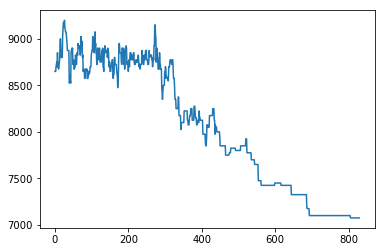

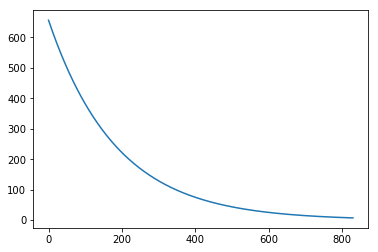

Starting class probabilties:  [ 0.22  0.05  0.21  0.51  0.01]
8650.0


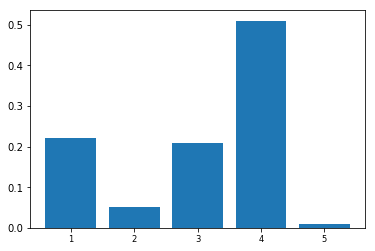

Ending class probabilties:  [ 0.09  0.14  0.14  0.36  0.27]
7075.0


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


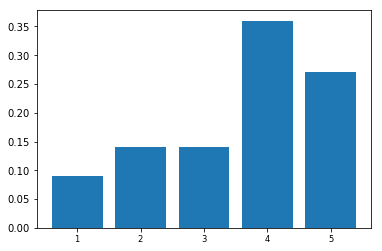

In [463]:
#if __name__ == '__main__':
bucket1_results = runSimulatedAnnealing(bucket1, schedules[0])
#bucket1_result_2 = runSimulatedAnnealing(bucket1, schedules[0], init_playlist=np.array(bucket1_result))

### Bucket 2 results: Any tracks from related artists

In [464]:
#bucket2_results = runSimulatedAnnealing(bucket2, schedules[1])

### Bucket 3 results: Similar tracks from related artists (manhattan distance + spotify API features)

Starting 0
Starting 1
Starting 2
Starting 3


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Te


[8100.0000000000009 8350.0 8675.0 8475.0]
Best index 0


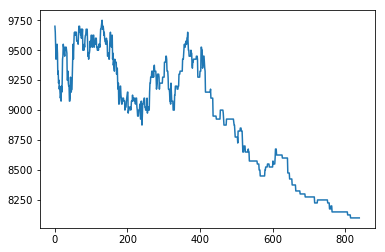

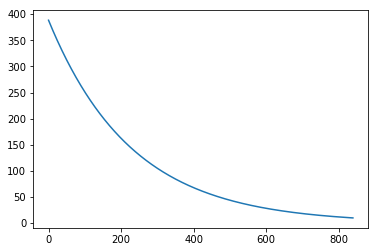

Starting class probabilties:  [ 0.39   0.165  0.325  0.12   0.   ]
9700.0


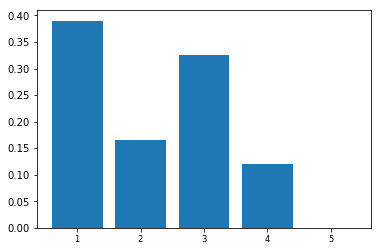

Ending class probabilties:  [ 0.2   0.09  0.13  0.49  0.09]
8100.0


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


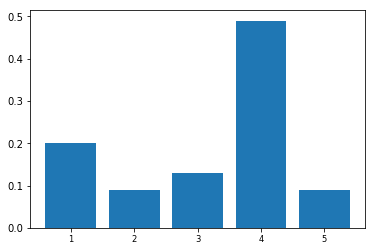

In [465]:
bucket3_results = runSimulatedAnnealing(bucket3, schedules[2])

In [466]:
# This got good results for all buckets
#auto_schedule

### Bucket 4 results: Similar tracks from vantage point database (earth mover's distance)

Starting 0
Starting 1
Starting 2
Starting 3


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Te

    57.00000       8500.00    50.00%    30.00%     0:00:56     0:00:00



[8325.0 8425.0 8600.0 8149.9999999999991]
Best index 3


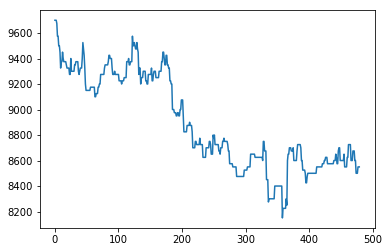

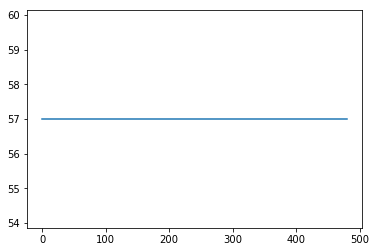

Starting class probabilties:  [ 0.39   0.165  0.325  0.12   0.   ]
9700.0


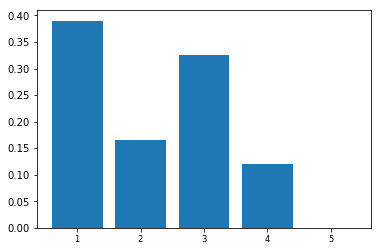

Ending class probabilties:  [ 0.17  0.08  0.17  0.5   0.08]
8150.0


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:303: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


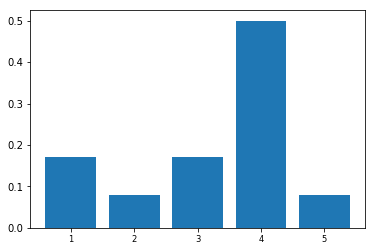

In [467]:
bucket4_results = runSimulatedAnnealing(bucket3, schedules[3])

### Format to put into a csv for the demo

In [468]:
all_dfs_tracks = []
all_dfs_probabilities = []
bucket_name = ["Top tracks from related artists", "Similar tracks from related artists", "Similar tracks from vantage point database"]
for index, result in enumerate([bucket1_results, bucket3_results, bucket4_results]):
    name = bucket_name[index]
    resulting_playlist = result[0]
    e, tsp, start, end, state, resulting_playlist_sim_anneal = result[1]
    tracks_output = pd.DataFrame({
    'seed_id': seed_id,
    'track_ids': resulting_playlist,
    'bucket_name': name,
    'track_order': list(range(len(resulting_playlist)))
    })
    probabilities = pd.DataFrame({
    'seed_id': seed_id,
    'bucket_name': name,
    'class': range(1,6),
    'probabilities': end
    })
    all_dfs_tracks.append(tracks_output)
    all_dfs_probabilities.append(probabilities)

In [469]:
playlist_data = all_dfs_tracks[0]
for each in all_dfs_tracks[1:]:
    playlist_data = playlist_data.append(each,ignore_index=True)
playlist_data

,bucket_name,seed_id,track_ids,track_order
0,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,1pGwXmkJy8oBfWAGqjHSgI,0
1,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,3d2APuMMFYWsA7g8AwV1Bd,1
2,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,3YcvFeJbnzDyWNxAFUhziH,2
3,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,2Yf7GDUIRd7YpA5LgqCeb5,3
4,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,1eBk1yNinU0VgY79rcshYa,4
5,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,567EmmCbOtpEuaVC2zznU6,5
6,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,6r44uyKRo3jKFRkThTZBXu,6
7,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,5WXoxLVNn7Bxrn0Q2RHfka,7
8,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,1UbvapOt3OIMhYv9ZOG6ZP,8
9,Top tracks from related artists,7k2lqQ4Vt9435X24qUISki,6qsnEjLjd29zqBCNIwEhl6,9


In [470]:
probabilities_data = all_dfs_probabilities[0]
for each in all_dfs_probabilities[1:]:
    probabilities_data = probabilities_data.append(each,ignore_index=True)
probabilities_data

,bucket_name,class,probabilities,seed_id
0,Top tracks from related artists,1,0.09,7k2lqQ4Vt9435X24qUISki
1,Top tracks from related artists,2,0.14,7k2lqQ4Vt9435X24qUISki
2,Top tracks from related artists,3,0.14,7k2lqQ4Vt9435X24qUISki
3,Top tracks from related artists,4,0.36,7k2lqQ4Vt9435X24qUISki
4,Top tracks from related artists,5,0.27,7k2lqQ4Vt9435X24qUISki
5,Similar tracks from related artists,1,0.20,7k2lqQ4Vt9435X24qUISki
6,Similar tracks from related artists,2,0.09,7k2lqQ4Vt9435X24qUISki
7,Similar tracks from related artists,3,0.13,7k2lqQ4Vt9435X24qUISki
8,Similar tracks from related artists,4,0.49,7k2lqQ4Vt9435X24qUISki
9,Similar tracks from related artists,5,0.09,7k2lqQ4Vt9435X24qUISki


### Make sure there are no duplicates

In [471]:
# playlist_data.to_csv('demo_playlists.csv', index=False)
# probabilities_data.to_csv('demo_probabilities.csv', index=False)

In [472]:
with open('demo_playlists.csv', 'a') as f:
    playlist_data.to_csv(f, header=False)
with open('demo_probabilities.csv', 'a') as f:
    probabilities_data.to_csv(f, header=False)

In [473]:
for df in all_dfs_tracks:
    print (df.shape)
    print(df.drop_duplicates(subset='track_ids', keep='first', inplace=False).shape)

(30, 4)
(30, 4)
(30, 4)
(30, 4)
(30, 4)
(30, 4)


In [474]:
all_dfs_tracks[2]

,bucket_name,seed_id,track_ids,track_order
0,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,5Nd50WKhVieaCLWFJlcLT2,0
1,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,7xj9wfY8g8wYywNDJYQtiw,1
2,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,7JLFGOAMkT5fCmjUeThGyu,2
3,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,4LvnlktZh4oLxpT7bFI34l,3
4,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,4viyKGiVj92VvsQCDTXrFE,4
5,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,2Y5YeET57EmS8GNr6zLQFf,5
6,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,0bVkyWFXvUyptosuyZN6RC,6
7,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,22IwVzhx2PnihV9zLkzPxk,7
8,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,4CRL20F12JmOo04JuVx3hv,8
9,Similar tracks from vantage point database,7k2lqQ4Vt9435X24qUISki,4ltvtgLNGlaVd8AUIgjUGt,9


### Alternatively, mix buckets together (e.g. take 60% similar songs, 40% top tracks)

## loss function over time, decay of temperature

In [475]:
def mixBuckets(bucket_one, bucket_two, bucket_two_ratio):
    n_sample_bucket_two = len(bucket_one)*bucket_two_ratio/(1-bucket_two_ratio)
    sample_bucket_two = np.random.choice(bucket_two, replace=False,size= n_sample_bucket_two)
    mixed_bucket = np.concatenate((bucket_one, bucket_two))
    return np.unique(mixed_bucket)

In [476]:
# mixed_bucket = mixBuckets(bucket1,bucket3,0.6)
# schedule_mixed = tuneSimAnneal(mixed_bucket)
# resulting_mixed = runSimulatedAnnealing(mixed_bucket, schedule_mixed)

### Resulting playlist!

In [477]:
all_dfs_tracks[2]['track_ids'].values

array([u'5Nd50WKhVieaCLWFJlcLT2', u'7xj9wfY8g8wYywNDJYQtiw',
       u'7JLFGOAMkT5fCmjUeThGyu', u'4LvnlktZh4oLxpT7bFI34l',
       u'4viyKGiVj92VvsQCDTXrFE', u'2Y5YeET57EmS8GNr6zLQFf',
       u'0bVkyWFXvUyptosuyZN6RC', u'22IwVzhx2PnihV9zLkzPxk',
       u'4CRL20F12JmOo04JuVx3hv', u'4ltvtgLNGlaVd8AUIgjUGt',
       u'2HXIrXCodF074SORlVWx4X', u'7DtmKZshOAzzmIzdH1IWpL',
       u'6iCX12NfJjqnkyyUiKOc2s', u'6NXl7R6bpf7q5g0B0hHYsn',
       u'6VI5dC7cZLu3hdUPq1loiJ', u'5xOgw2iE0qvcGYSErgLiJ6',
       u'7cinlbzzEWJtJjDkDmx5O4', u'7FUDF5tlStRHxO7ZqjcFd2',
       u'0fTTbpS94BPYxan1Z6J3cm', u'7JRbXhWVB6i20wPHx0M6vd',
       u'2TTwSbzdUsJPKioJ868N9D', u'7j3QsdzlQS7juDbMpAkx2y',
       u'3G9pm7y3lVQ1FFANURCgVU', u'0NmYSVa2CyMCd9XU2vGjoA',
       u'3TNrH1JTapEGqL7vNlmrIC', u'3xev4ldjHq7qLz6XfgE7G4',
       u'37dXg6Z50WBk8u6O3w0URY', u'35vtXtNRBB0VP3XBnUSdo6',
       u'7xm9QD5D4RqUxhAO5H7ouW', u'79PzUCoYq6Co89mxICQOH8'], dtype=object)

In [479]:
from IPython.core.display import display, HTML

for each in all_dfs_tracks[0]['track_ids'].values:
    #song_id = related_all_features_with_seed[related_all_features_with_seed['id']==each]['id'].values[0]
    #link='<a href=' + related_all_features_with_seed[related_all_features_with_seed['id']==each]['preview_url'].values[0] + '>preview related song</a>'
    #print(related_all_features_with_seed[related_all_features_with_seed['id']==each]['artists'].values[0])
    link = "<iframe src=\"https://open.spotify.com/embed?uri=spotify:track:" + each + "\"frameborder=\"0\" allowtransparency=\"true\"></iframe>"
    #print(link)
    display(HTML(link))
